In [4]:
from scipy.spatial import distance_matrix
from PIL import Image
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
inputpath = 'Zurich_Views/'
outputpath = 'Zurich_Files/SegmentedImages/'
featurespath = 'Zurich_Files/'

number_of_views = 1010

# Image Segmentation

## Based on distances to centroids

First segment the images

In [9]:
#Setup cluster centers for segmentation
cluster_centers=[]

#These are all naive attempts that didn't work well/were unnecessary
# cluster_centers.append([255,0,0])       #red
# cluster_centers.append([220,110,90])    #light red
# cluster_centers.append([125,0,0])       #dark red
# cluster_centers.append([125,255,0])     #green
# cluster_centers.append([125,255,125])   #light green
# cluster_centers.append([200,200,200])   #light grey
# cluster_centers.append([0,0,255])       #blue
# cluster_centers.append([125,180,200])   #light blue
# cluster_centers.append([180,200,255])   #light purple
# cluster_centers.append([0,0,125])       #dark blue
# cluster_centers.append([255,255,0])     #yellow
# cluster_centers.append([255,160,50])    #beige


#Final clusters choice
cluster_centers.append([0,0,0])         #black

cluster_centers.append([70,70,70])      #dark grey
cluster_centers.append([125,125,125])   #grey
cluster_centers.append([180,180,180])   #light grey

cluster_centers.append([255,255,255])   #white

cluster_centers.append([50,70,0])       #dark green
cluster_centers.append([160,160,90])    #light green

cluster_centers.append([90,120,145])    #dark blue
cluster_centers.append([130,160,190])   #light blue

cluster_centers.append([100,40,30])      #dark red
cluster_centers.append([210,100,90])     #red
cluster_centers.append([120,110,100])    #orange/brown

cluster_centers=np.array(cluster_centers)    

rows = 600
cols = 600

def open_image(nb):
    """ Open image to segment and make a flattened copy
        INPUT:
            - (int) nb: index of the image to open
        OUTPUT:
            - (array <rows>x<cols>) original_image 
            - (array <rows>*<cols>x1) flattened_image 
    """
    #Open original image
    image_path = inputpath + str(nb) + ".jpg"
    original_image = Image.open(image_path)

    #Flatten the image
    flattened_image = np.array(original_image)
    flattened_image = flattened_image.reshape(rows*cols, 3)
    return original_image, flattened_image

def segment_images(nb_images):
    """ Segment images in the Data/CleanedImages folder, from 0.jpg to (<nb_images> - 1).jpg
        INPUT:
            - (int) nb_images: number of images to segment
        OUTPUT:
            - (array nb_imagesx<rows>x<cols>) images_labels: a tensor containing the labels (from 0 to 11) for each pixel for each image 
    """
    
    #Prepare the output, which is a matrix whose lines correspond to each image, and columns to the pixels. The value is the label of the class this pixel in this image belongs to.
    images_labels = np.zeros((nb_images,rows*cols))

    for i in range(nb_images):

        #Open the image
        original_image, flattened_image = open_image(i)

        #Assign the labels based on the distance to the cluster centers.
        dist_mat = distance_matrix(flattened_image, cluster_centers)
        assignments = np.argmin(dist_mat, axis=1)

        #Replace each pixel value with its nearby centroid
        segmented_image = cluster_centers[assignments]
        images_labels[i] = assignments
        segmented_image = np.clip(segmented_image.astype('uint8'), 0, 255)

        #Reshape the image to original dimension
        segmented_image = segmented_image.reshape(rows, cols, 3)

        #Save the segmented image in the folder
        output_path = outputpath + str(i) + ".jpg"
        im = Image.fromarray(segmented_image)
        im.save(output_path)

        #Print a result every 20 steps
        if(i % 100 == 0):
            print("Image " + str(i))
            fig = plt.figure()

            #Visualize segmented images against original

            ax1 = fig.add_subplot(1, 2, 1)
            ax1.imshow(original_image, cmap='Greys_r')
            ax2 = fig.add_subplot(1, 2, 2)
            ax2.imshow(segmented_image, cmap='Greys_r')
            plt.tight_layout()
            plt.show()

    return images_labels

Image 0


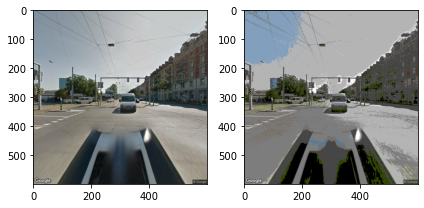

Image 100


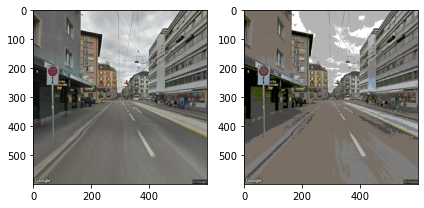

Image 200


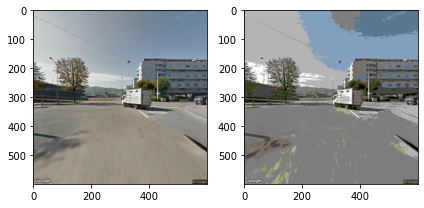

Image 300


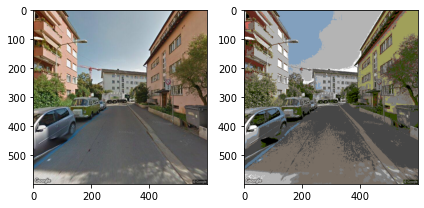

Image 400


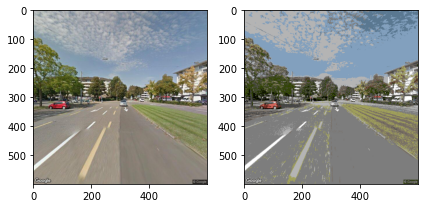

Image 500


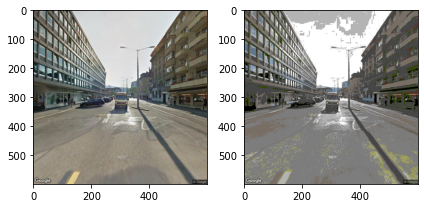

Image 600


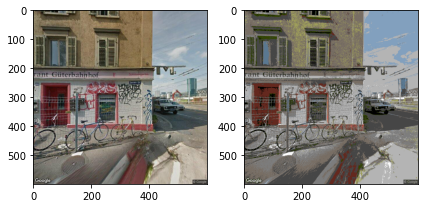

Image 700


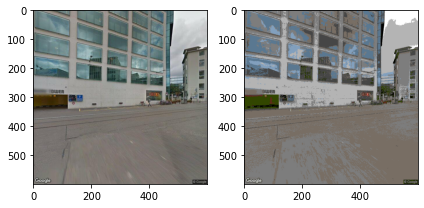

Image 800


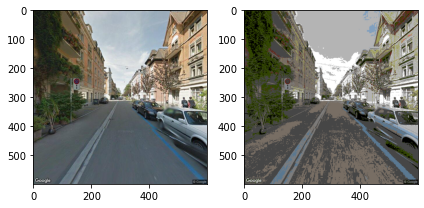

Image 900


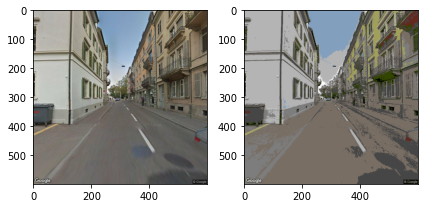

Image 1000


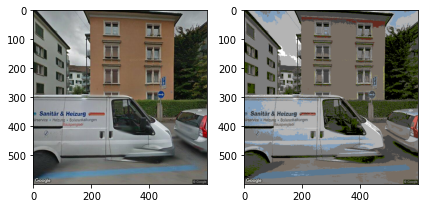

In [10]:
images_labels = segment_images(number_of_views)

Get color classes from segmentation by counting number of pixels in each of the 12 classes

In [11]:
def get_info_images_labels(nb_images):
    """ Extract the number of pixels in each of the 12 classes for the <nb_images> images.
        INPUT:
            - (int) nb_images: number of images to extract the info from
        OUTPUT:
            - (array nb_imagesx12) features: a tensor containing the number of pixels in each classfor each image 
    """

    #Prepare output
    features = np.zeros((nb_images, cluster_centers.shape[0]))

    #Loop over all images
    for n in range(nb_images):
        #Recover the pixel labels of this image
        labels = images_labels[n]

        #Count the number of labels equal to each class
        for k in range(cluster_centers.shape[0]):
            features[n,k] = np.count_nonzero(labels == k)       
        
    return features

features = get_info_images_labels(number_of_views)

#Store the computed features in a dataframe
df = pd.DataFrame(features)

df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,12364.089109,80379.345545,58511.525743,72514.524752,15914.737624,21316.107921,5216.319802,3906.985149,13731.139604,4072.270297,352.358416,71720.596040
std,9525.814068,45840.724157,39917.996274,40190.288362,11676.280030,15622.331306,6485.975950,8057.903137,16155.179350,5395.716443,1428.290412,41698.125438
min,335.000000,10947.000000,108.000000,100.000000,163.000000,806.000000,0.000000,0.000000,15.000000,0.000000,0.000000,580.000000
25%,6031.000000,47607.750000,25634.250000,43166.000000,6933.500000,10359.500000,1064.500000,498.250000,2641.500000,794.000000,1.000000,38287.750000
50%,10032.000000,66729.500000,47638.000000,64975.000000,14050.500000,16945.500000,2974.500000,1426.000000,6884.000000,2112.000000,22.500000,58309.000000
75%,15536.250000,104967.250000,86488.250000,96634.250000,22454.750000,28316.250000,6598.000000,3550.500000,18943.500000,5233.750000,130.000000,104637.000000
max,72845.000000,330969.000000,163692.000000,210281.000000,85078.000000,154589.000000,53431.000000,70690.000000,91241.000000,56685.000000,18611.000000,203797.000000


Create the final dataframe containing only the main classes by regrouping the subclasses together. 
One class can be omitted because it is fully correlated with the rest:
if the pixel is not in any of the first 5 classes, then it is necessarily in the last one. 
So we can remove one main class, here the 'Red' one.

In [12]:
final_df = pd.DataFrame()

final_df['Black'] = df.iloc[:,0]

#Aggregate the subclasses 'Dark grey', 'Grey', 'Light grey'
final_df['Grey'] = df.iloc[:,1] + df.iloc[:,2] + df.iloc[:,3]

final_df['White'] = df.iloc[:,4]

#Aggregate the subclasses 'Dark green', 'Light green'
final_df['Green'] = df.iloc[:,5] + df.iloc[:,6]

#Aggregate the subclasses 'Dark blue', 'Light blue'
final_df['Blue'] = df.iloc[:,7] + df.iloc[:,8]

# #Aggregate the subclasses 'Dark red', 'Red', 'Orange/brown' (NOT NECESSARY)
# final_df['Red'] = df.iloc[:,9] + df.iloc[:,10] + df.iloc[:,11] 


final_df.describe()

,Black,Grey,White,Green,Blue
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,12364.089109,211405.396040,15914.737624,26532.427723,17638.124752
std,9525.814068,40729.201392,11676.280030,16909.015872,20132.608114
min,335.000000,99975.000000,163.000000,1981.000000,15.000000
25%,6031.000000,183823.750000,6933.500000,13911.000000,4166.500000
50%,10032.000000,211766.500000,14050.500000,22388.500000,10220.500000
75%,15536.250000,240153.500000,22454.750000,35501.500000,22512.000000
max,72845.000000,331177.000000,85078.000000,154601.000000,120511.000000


In [13]:
#Export final segmentation to csv
final_df.to_csv(featurespath + 'Color_features.csv')